In [9]:
%load_ext autoreload

%autoreload 2
    
%matplotlib inline
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from torchir.utils import IRDataSet
from torch.utils.data import Dataset
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Define a custom dataset for loading 3D CT images
class CTDataSet(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load NIFTI image
        image = nib.load(self.image_paths[idx]).get_fdata()
        
        # Convert the image data to float32 type, as PyTorch's default is float32
        image = np.asarray(image, dtype=np.float32)

        # Add channel dimension: [1, depth, height, width]
        image = np.expand_dims(image, axis=0)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [11]:
# Define the path to the directory containing NIFTI images
image_dir = Path("E:/s4692034/thorax_resampled")
image_paths = [str(p) for p in image_dir.glob("*.nii")]
# print(f"Found {len(image_paths)} images")

# TODO: how to make the network accept different matrix size
transform = None

# Create an instance of the CTDataSet
ct_dataset = CTDataSet(image_paths=image_paths, transform=transform)

# Use the IRDataSet wrapper to produce pairs for registration tasks
registration_dataset = IRDataSet(ct_dataset)

In [12]:
from torch.utils.data import random_split

# Set up a random number generator
rng = np.random.default_rng(617)

# Split the dataset into training, validation, and test sets
val_set_size = 20
test_set_size = 80
train_set_size = len(ct_dataset) - val_set_size - test_set_size

ds_train_subset, ds_validation_subset, ds_test_subset = random_split(ct_dataset, [train_set_size, val_set_size, test_set_size], 
                                                        generator=torch.Generator().manual_seed(617))

print(f'Training subset size: {len(ds_train_subset)}')
print(f'Validation subset size: {len(ds_validation_subset)}')
print(f'Test subset size: {len(ds_test_subset)}')

Training subset size: 329
Validation subset size: 20
Test subset size: 80


In [13]:
import pytorch_lightning as pl
from torchir.metrics import NCC
from torchir.dlir_framework import DLIRFramework
from torchir.networks import DIRNet
from torchir.transformers import BsplineTransformer

class LitDLIRFramework(pl.LightningModule):
    def __init__(self, only_last_trainable=True):
        super().__init__()
        self.dlir_framework = DLIRFramework(only_last_trainable=only_last_trainable)
        self.add_stage = self.dlir_framework.add_stage
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.002
        weight_decay = 0
        optimizer = torch.optim.Adam(self.dlir_framework.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)
        return {'optimizer': optimizer}

    def forward(self, fixed, moving):
        warped = self.dlir_framework(fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss
    
    def on_epoch_end(self):
        torch.cuda.empty_cache()

In [16]:
def visualize(num_samples=3):
    # Load the model from the checkpoint
    model = LitDLIRFramework()
    model.add_stage(network=DIRNet(grid_spacing=(8, 8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2, ndim=3),
                    transformer=BsplineTransformer(ndim=3, upsampling_factors=(8, 8, 8)))
    model.add_stage(network=DIRNet(grid_spacing=(4, 4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2, ndim=3),
                    transformer=BsplineTransformer(ndim=3, upsampling_factors=(4, 4, 4)))

    # Load checkpoint
    checkpoint = torch.load("C:\\Users\\s4692034\\Downloads\\pet-ct_dlir_8_4.ckpt")

    corrected_state_dict = {f"dlir_framework.{k.replace('dlir_framework.', '')}": v for k, v in checkpoint['state_dict'].items()}

    # Load the corrected_state_dict into model6
    model.load_state_dict(corrected_state_dict)

    model = model.cuda()
    model.eval()

    # Select a few random samples
    indices = np.random.choice(len(ds_test_subset), size=num_samples, replace=False)

    # Plot the samples
    fig, axs = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            fixed = ds_test_subset[0]
            moving = ds_test_subset[idx]

            if isinstance(fixed, np.ndarray):
                fixed = torch.tensor(fixed)
            if isinstance(moving, np.ndarray):
                moving = torch.tensor(moving)

            warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()

            nifti_image = nib.Nifti1Image(warped, affine=np.eye(4))
            nib.save(nifti_image, f"./CT_output/warped_sample_{i+1}.nii")
            
            slice_idx = 80  # This can be parameterized as well

            # Plot Fixed Image
            axs[i, 0].imshow(fixed.squeeze().cpu().numpy()[:, :, slice_idx], cmap='gray')
            axs[i, 0].set_title(f'Sample {i+1}: Fixed Image')
            axs[i, 0].axis('off')

            # Plot Moving Image
            axs[i, 1].imshow(moving.squeeze().cpu().numpy()[:, :, slice_idx], cmap='gray')
            axs[i, 1].set_title(f'Sample {i+1}: Moving Image')
            axs[i, 1].axis('off')

            # Plot Warped Image
            axs[i, 2].imshow(warped[:, :, slice_idx], cmap='gray')
            axs[i, 2].set_title(f'Sample {i+1}: Warped Image')
            axs[i, 2].axis('off')

            # Plot Difference Image
            difference = np.abs(warped - fixed.squeeze().cpu().numpy())
            axs[i, 3].imshow(difference[:, :, slice_idx], cmap='hot')
            axs[i, 3].set_title(f'Sample {i+1}: Difference Image')
            axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


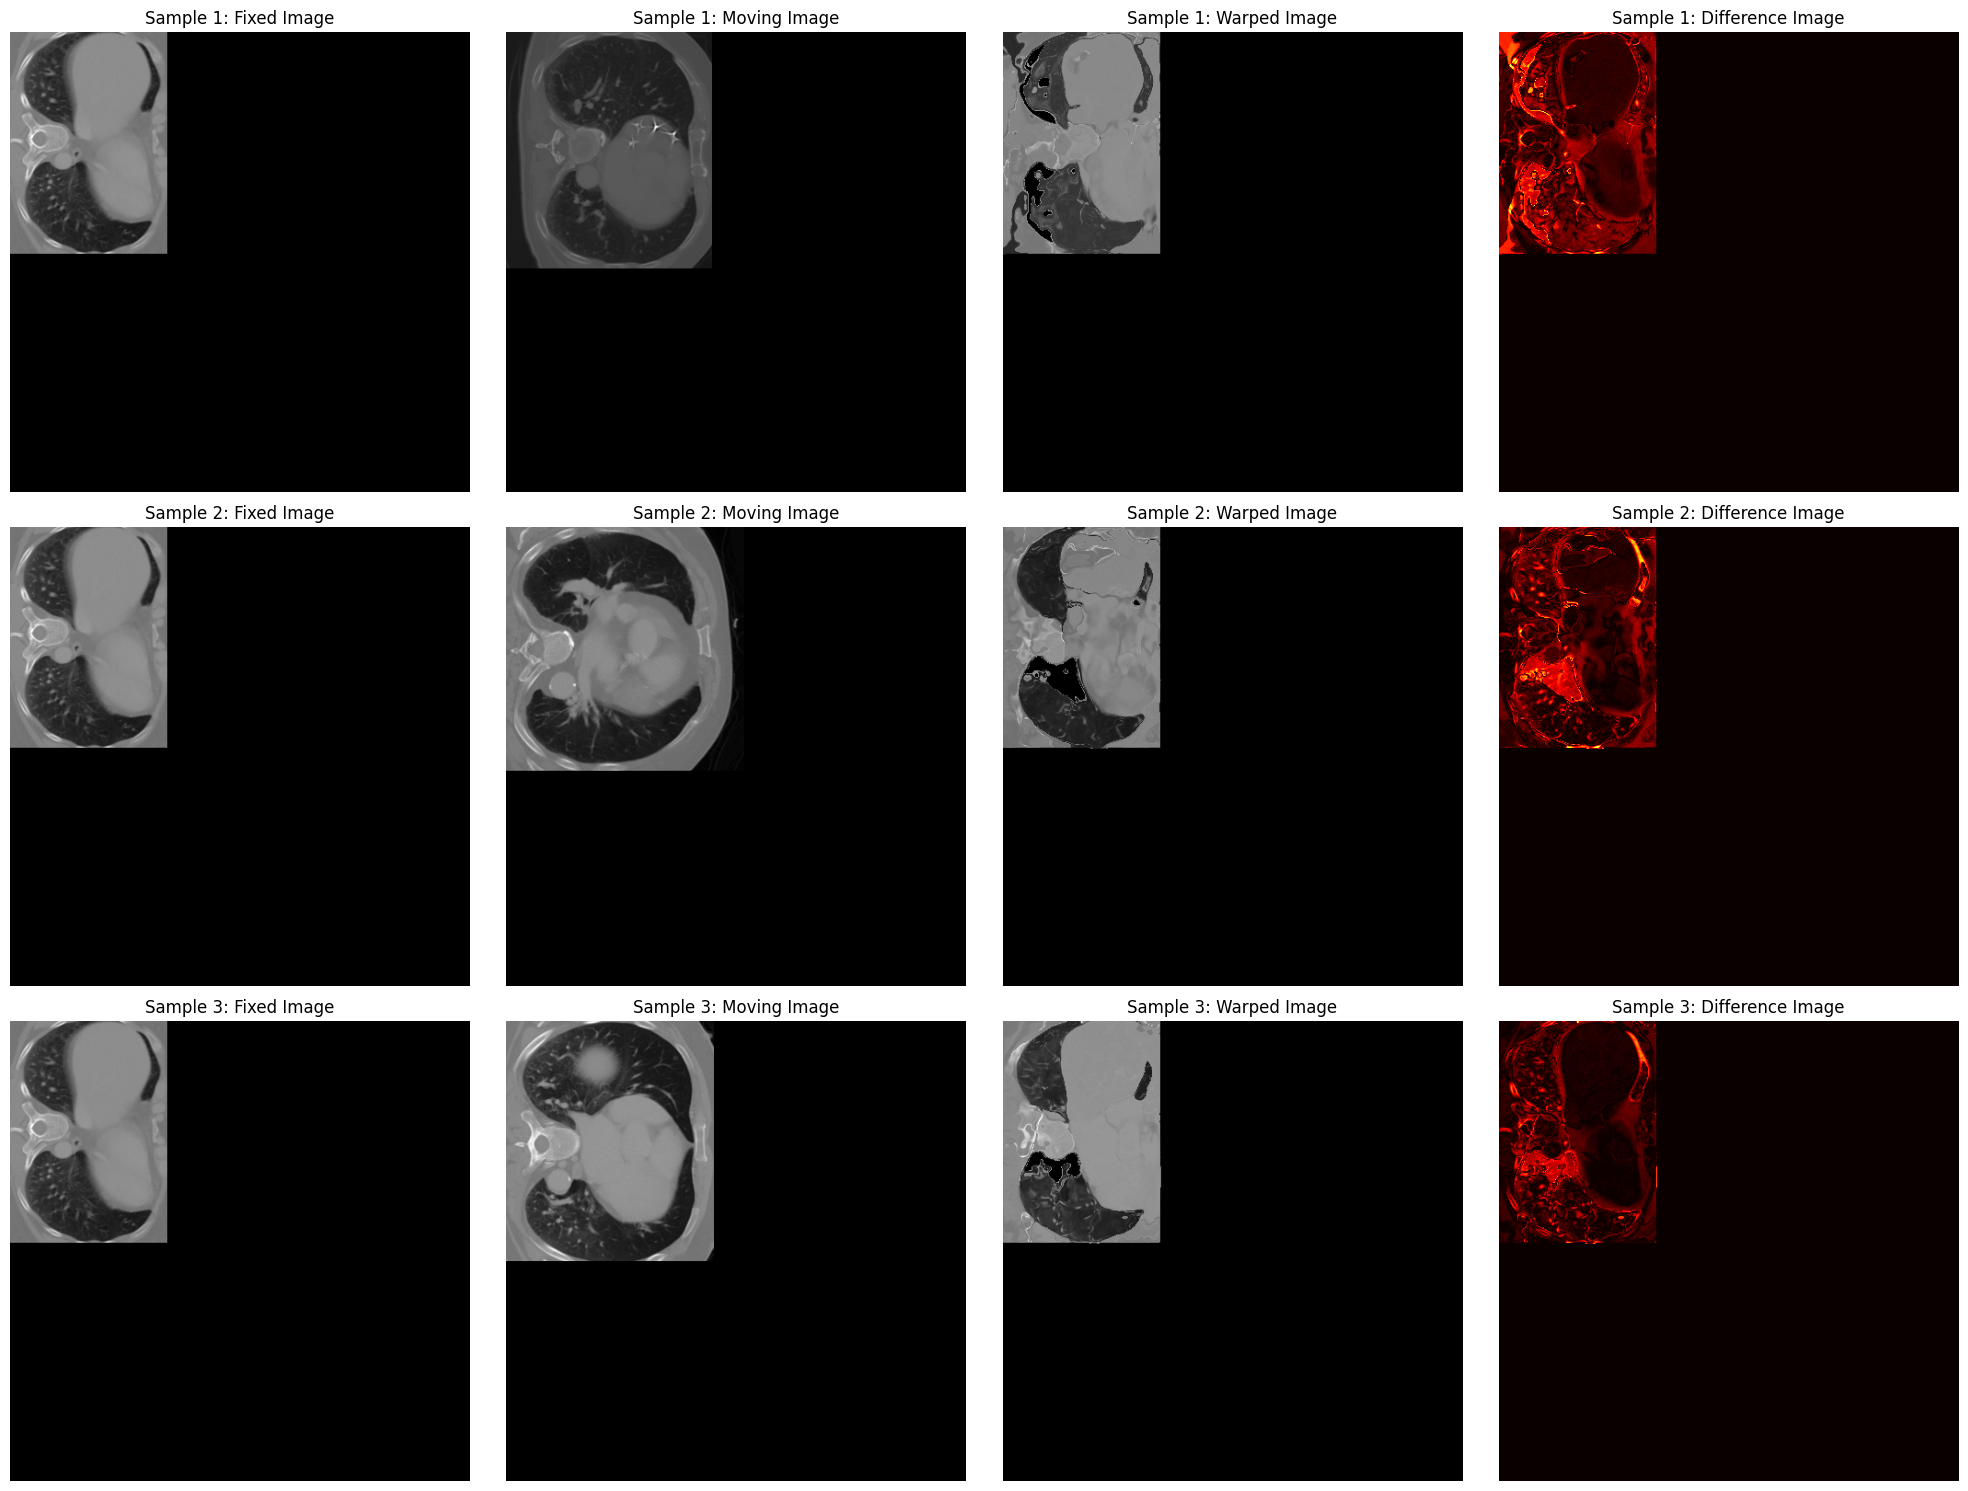

In [17]:
visualize(num_samples=3)